# Monte Carlo Estimator

---

Monte Carlo methods are a class of computational algorithms that solve problems by simulating random samples and aggregating their results to approximate solutions. They are particularly useful when analytical or exact solutions are difficult or impossible to obtain.

## Concept

Suppose we want to compute a quantity $\theta$ that can be written as an expectation:
$$
\theta = \mathbb{E}[f(X)].
$$
If $X$ has probability density $p(x)$, this is equivalent to the integral:
$$
\theta = \int_{\mathcal{X}} f(x)\, p(x)\, dx.
$$


Draw $N$ i.i.d. samples $X_1, \dots, X_N \sim p(x)$, then the Monte Carlo estimator is the sample mean:
$$
\hat{\theta}_N = \frac{1}{N} \sum_{i=1}^N f(X_i).
$$


## Convergence

By the **Weak Law of Large Numbers (LLN)**:
$$
\hat{\theta}_N \xrightarrow{p} \theta \quad \text{as } N \to \infty,
$$
i.e., the estimator converges to the true integral.

## Error


If $\sigma^2 = \mathrm{Var}(f(X)) < \infty$, then for large $N$:
$$
\sqrt{N}(\hat{\theta}_N - \theta) \xrightarrow{d} \mathcal{N}(0, \sigma^2),
$$
or equivalently:
$$
\hat{\theta}_N \approx \mathcal{N}\Big(\theta, \frac{\sigma^2}{N}\Big).
$$


## Confidence Intervals (CI)

A $100(1-\alpha)\%$ CI for $\theta$ is:
$$
\hat{\theta}_N \pm z_{\alpha/2} \frac{\sigma}{\sqrt{N}}
$$
If $\sigma$ is unknown, estimate from samples:
$$
\hat{\sigma}^2 = \frac{1}{N-1} \sum_{i=1}^N (f(X_i) - \hat{\theta}_N)^2, \quad 
\hat{\theta}_N \pm z_{\alpha/2} \frac{\hat{\sigma}}{\sqrt{N}}.
$$

## Example 1: Definite integral over $[a,b]$

We can write
$$
\theta = \int_a^b f(x)\, dx = (b-a)\, \mathbb{E}[f(U)]
$$
where
$$\quad U \sim \text{Uniform}[a,b]
$$


We can define the Monte Carlo estimator:
$$
\hat{\theta}_N = \frac{b-a}{N} \sum_{i=1}^N f(U_i).
$$

## Implementation

In [1]:
import logging
import math
import random
from dataclasses import dataclass
from types import TracebackType
from typing import Optional, Type

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

from theoria.validor import TestCase, Validor

In [2]:
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
if not log.hasHandlers():
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter("[%(asctime)s] [%(levelname)s] %(message)s"))
    log.addHandler(handler)

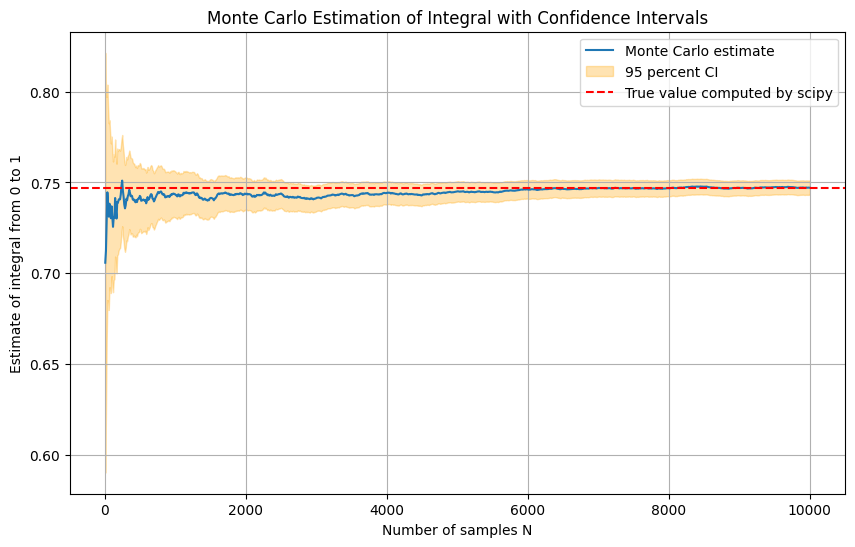

In [3]:
# Function to integrate
def f(x):
    return np.exp(-(x**2))


# Compute true integral using scipy
true_integral, _ = quad(f, 0, 1)

# Total number of samples
N_total = 10000
sample_sizes = np.arange(10, N_total + 1, 10)

# Generate uniform samples in range 0 to 1
x_samples = np.random.uniform(0, 1, N_total)
f_samples = f(x_samples)

# Monte Carlo estimates and confidence intervals
estimates = []
ci_lower = []
ci_upper = []

for N in sample_sizes:
    sample = f_samples[:N]
    mean_est = np.mean(sample)
    estimates.append(mean_est)

    # Sample standard deviation
    sigma_hat = np.std(sample, ddof=1)
    se = sigma_hat / np.sqrt(N)

    # 95 percent confidence interval
    ci_lower.append(mean_est - 1.96 * se)
    ci_upper.append(mean_est + 1.96 * se)

estimates = np.array(estimates)
ci_lower = np.array(ci_lower)
ci_upper = np.array(ci_upper)

# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, estimates, label="Monte Carlo estimate")
plt.fill_between(
    sample_sizes, ci_lower, ci_upper, color="orange", alpha=0.3, label="95 percent CI"
)
plt.axhline(
    true_integral, color="red", linestyle="--", label="True value computed by scipy"
)
plt.xlabel("Number of samples N")
plt.ylabel("Estimate of integral from 0 to 1")
plt.title("Monte Carlo Estimation of Integral with Confidence Intervals")
plt.legend()
plt.grid(True)
plt.show()

## Example 2: Estimation of $\pi$

Estimate $\pi$ using MC sampling. 

Consider a square $S$ of length $2r$, of which inside is a circle $C$ with radius $r$.

The area $A$ of each is:
$$
\begin{align*}
A_{S} &= 4r^2 \\
A_{C} &= \pi r^2 \\
\end{align*}
$$

Thus:
$$
\frac{\pi}{4} = \frac{A_C}{A_S} 
$$

So we can approximately expect that if we randomly sample (throw points) in $[0, r] \times [0, r]$, about $\frac{\pi}{4}$ of those land in the circle.

More precisely we calculate
$$
\pi = \int_{-r}^r \int_{-r}^r \mathbb{I}(x^2 + y^2 \leq r^2) \, dx \, dy
$$
and the MC estimator is
$$
\hat{\pi}_{N} \approx \frac{4}{N} \sum_{k=1}^N \mathbb{I}(x_k^2 + y_k^2 \leq r^2)
$$
where $\mathbb{I}$ is the indicator function.

In [4]:
@dataclass
class MonteCarloResult:
    result: float
    num_samples: int


class MonteCarloPi:
    def __init__(self, seed: int = 42):
        self.seed = seed
        self._original_state = None

    def __enter__(self):
        self._original_state = random.getstate()
        random.seed(self.seed)
        return self

    def __exit__(
        self,
        exc_type: Optional[Type[BaseException]],
        exc_value: Optional[BaseException],
        traceback: Optional[TracebackType],
    ) -> Optional[bool]:
        if self._original_state:
            random.setstate(self._original_state)
        return None

    def __call__(self, num_samples: int, radius: float = 1.0) -> float:
        inside_circle = 0
        for _ in range(num_samples):
            x = random.uniform(0, radius)  # noqa: S311
            y = random.uniform(0, radius)  # noqa: S311

            distance = x**2 + y**2
            if distance <= radius**2:
                inside_circle += 1

        return MonteCarloResult(
            result=4 * inside_circle / num_samples,
            num_samples=num_samples,
        )

    def __del__(self):
        if self._original_state:
            random.setstate(self._original_state)

In [5]:
test_cases = [
    TestCase(
        input_data={"num_samples": int(1e2)},
        expected_output=math.pi,
        description="1e2 samples",
    ),
    TestCase(
        input_data={"num_samples": int(1e4)},
        expected_output=math.pi,
        description="1e4 samples",
    ),
    TestCase(
        input_data={"num_samples": int(1e6)},
        expected_output=math.pi,
        description="1e6 samples",
    ),
]

In [6]:
def comparison(actual: MonteCarloResult, expected: float) -> bool:
    # Slightly relaxed tolerance based on number of samples
    # Expect 1 / sqrt(N) convergence
    tolerance = 10 / math.sqrt(actual.num_samples)
    result = actual.result
    log.info(f"Comparing {result=} with {expected=} with relative {tolerance=}")
    return math.isclose(result, expected, rel_tol=tolerance)


with MonteCarloPi() as mc:
    Validor(mc).add_cases(test_cases).run(comparison=comparison)

[2025-12-06 08:25:30,631] [INFO] Comparing result=3.12 with expected=3.141592653589793 with relative tolerance=1.0


[2025-12-06 08:25:30,636] [INFO] Comparing result=3.1252 with expected=3.141592653589793 with relative tolerance=0.1


[2025-12-06 08:25:31,062] [INFO] Comparing result=3.140828 with expected=3.141592653589793 with relative tolerance=0.01


[2025-12-06 08:25:31,062] [INFO] All 3 tests passed for <__main__.MonteCarloPi object at 0x7faa1b12b8f0>.
